# Определение возраста покупателей

<h1> Описание</h1>
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Подгрузим всё, необходимое для работы.

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

Загрузим данные

In [3]:
data.shape

(7591, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим на данные

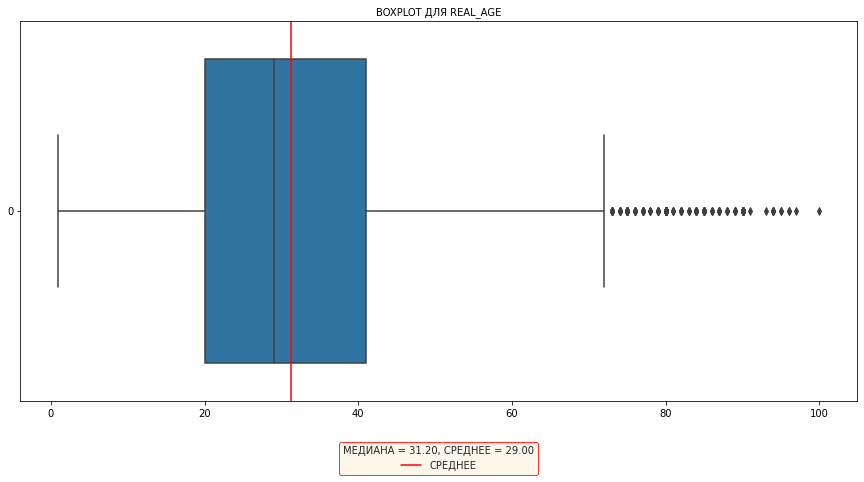

In [6]:
plt.figure(figsize=[15, 7])
plt.title(f'BOXPLOT ДЛЯ REAL_AGE', fontsize=10)
sns.set_style('darkgrid')
sns.boxplot(data=data['real_age'], orient='h')
plt.axvline(np.mean(data['real_age']), 
            color='r', 
            linestyle='-',
            label='СРЕДНЕЕ')
median = np.mean(data['real_age'])
mean = np.median(data['real_age'])
plt.legend(title=f'МЕДИАНА = {median:.2f}, СРЕДНЕЕ = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.15));

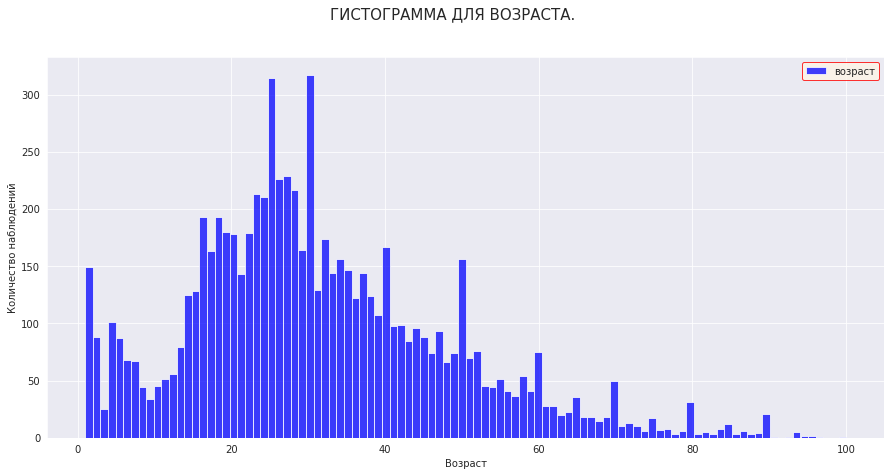

In [7]:
plt.figure(figsize=[15, 7])
plt.suptitle('ГИСТОГРАММА ДЛЯ ВОЗРАСТА.', fontsize=15)
sns.set_style('darkgrid')
sns.histplot(data=data['real_age'], color='b', label='возраст',bins=100, kde=False)
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.legend(edgecolor = 'r', facecolor = 'oldlace')
plt.show();

Посмотрим распределение возрастов

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                      directory='/datasets/faces/final_files/',
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      seed = 12345)

Found 7591 validated image filenames.


In [9]:
features, target = next(train_datagen_flow)

In [10]:
print('Размер выборки -', features.shape)

Размер выборки - (32, 224, 224, 3)


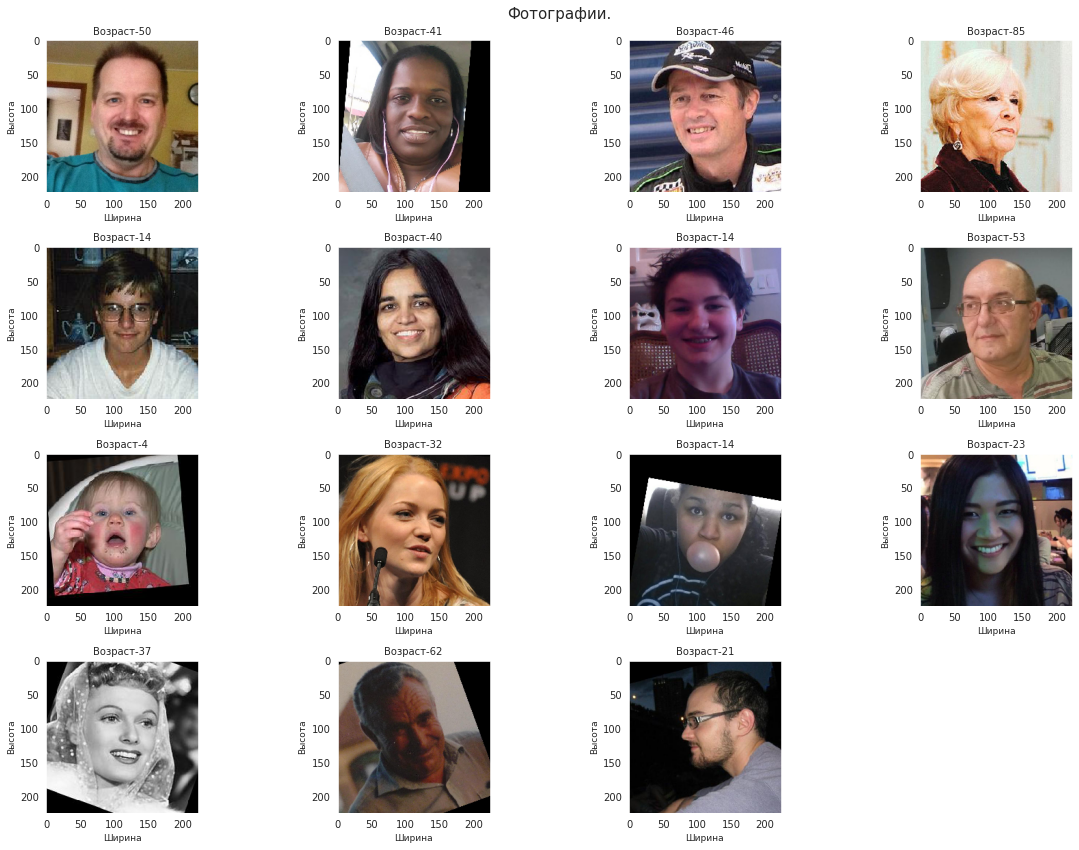

In [11]:
fig = plt.figure(figsize=(17,12))
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)
for i in range(15):
    plt.suptitle('Фотографии.', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
plt.tight_layout()

<h1>Вывод</h1>
<ol>

<li>В данных 7591 фотография</li>

<li>Большая часть Людей на фото в возрасте от 21 до 40 лет</li>

<li>Есть ЧБ фотографии, под углом, разных размеров, к тому же есть фото с лишними объектами перед лицом(жвачка, микрофон и пр.)</li>

<li>Общая ориненатция фотографий в основном правильная, но некоторые под довльно сильным углом(вплоть до 90 гралдусов)</li>
<li>Пики в юбилейных возрастах взялись, предположительно из-за того, что люди в юбилей фотографируются больше, нежели в обычные даты.</li>
<li>Разметка выполнена корректно</li>
<li>Качество данных не самое лучшее, их необходимо обогатить.</li>
</ol>

## Обучение модели

```python
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                      directory=path+'/final_files',    
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      subset='training',  
                                                      seed = 12345)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                         directory=path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',     
                                                         seed = 12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
      


   
# < скопируйте код сюда >

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-21 21:56:53.677364: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-21 21:56:54.167779: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 110s - loss: 294.5100 - mae: 12.5205 - val_loss: 698.6328 - val_mae: 21.4812
Epoch 2/10
178/178 - 89s - loss: 118.1622 - mae: 8.1958 - val_loss: 481.2846 - val_mae: 16.6792
Epoch 3/10
178/178 - 88s - loss: 100.8308 - mae: 7.5871 - val_loss: 314.4513 - val_mae: 13.1839
Epoch 4/10
178/178 - 88s - loss: 84.3772 - mae: 6.9776 - val_loss: 125.3787 - val_mae: 8.5667
Epoch 5/10
178/178 - 88s - loss: 72.5015 - mae: 6.5023 - val_loss: 96.3381 - val_mae: 7.3782
Epoch 6/10
178/178 - 88s - loss: 67.4346 - mae: 6.2673 - val_loss: 80.5660 - val_mae: 6.9621
Epoch 7/10
178/178 - 88s - loss: 61.1549 - mae: 5.9710 - val_loss: 127.3368 - val_mae: 8.4170
Epoch 8/10
178/178 - 88s - loss: 57.8611 - mae: 5.8449 - val_loss: 100.4298 - val_mae: 7.3453
Epoch 9/10
178/178 - 88s - loss: 51.3704 - mae: 5.4883 - val_loss: 76.0843 - val_mae: 6.4214
Epoch 10/10
178/178 - 88s - loss: 46.3594 - mae: 5.2377 - val_loss: 81.1847 - val_mae: 6.6691
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 81.1847 - mae: 6.6691
Test MAE: 6.6691

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Для получения наилучшего качества модели я использовал аугментацию данных, а так же алгоритм Adam с частотой обучения lr=0.0001 и архитектуру RestNet50, с количеством эпох 10

<h1>Заключение</h1>
При обучение модели получена отметка MAE ниже 8. Так как качество данных было "не на высоте", для корректного обучения модели пришлось использовать следующие методы:

<ul><li>aугментация данных

Горизонтальное отражение фотографий и сдвиг по ширине/высоте (добавлние фотографий, неотличимых от настоящих) позволит увеличить выборку. поможет увеличить качество обучения модели.</li>

<li>алгоритм Adam(lr=0.0001)

Чем ниже скорость обучения(шаг градиентного спуска), тем лучше подбираются параметры для нейронов.</li>


<li>архитектура RestNet50(weights='imagenet')</li>
    </ul>
Инициализация весов 'ImageNet'. ImageNet - название большого датасета. Для повышения качества модели начнем обучать ее на данном датасете, а продолжим на своем.

Считаю, что полученная модель позволит эффективно решить задачу по определению возраста покупателя для предложения ему интересных товаров, но, в то же время, применять нашу модель для помощи кассиру в определении возраста при продаже алкоголя нельзя (ошибка в 6 с лишним лет критична в данном случае).